# 🧪 Lab: Modelling & Model Lifecycle — Predicting Plant Production (GIST Steel Dataset)

---

## 🎯 Learning Outcomes

By completing this lab, you will be able to:

- Prepare and analyse a dataset for modelling.  
- Train and evaluate regression models.  
- Apply cross-validation and hyperparameter tuning using scikit-learn.  
- Track experiments and store models using MLflow and/or Optuna.  
- Reflect on the practical aspects of managing the ML lifecycle.

---



## 🧩 1. Data Setup and Exploration
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Understand the dataset structure and the target variable (“plant-level production”).

---

### **Task 1.1 – Load and Inspect Data**
- Load the GIST Steel dataset. 
- Display basic info (shape, column names, missing values, and data types).  
- Identify the target variable (production) and key features (capacity, ...).


In [423]:
import pandas as pd

In [424]:
# Load datasets
plant_data = pd.read_excel('Plant_data.xlsx')
plant_capacities = pd.read_excel('plant_capacities_and_status.xlsx')
plant_level = pd.read_excel('Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx') 

In [425]:
# merge all dataframes on 'Plant ID'
steel_plants = plant_data.merge(plant_capacities, on='Plant ID', how='left')
steel_plants = steel_plants.merge(plant_level, on='Plant ID', how='left')

# Display the first few rows of the merged dataframe
print('All columns of the merged dataframe, with datatypes:')
# print(steel_plants.info())
print('\nMissing values in each column:')
# print(steel_plants.isnull().sum())


All columns of the merged dataframe, with datatypes:

Missing values in each column:


In [426]:
# Basic info about the data
print("shape: ",steel_plants.shape)

shape:  (4213, 66)



> 📝 *Markdown prompt:*  
Describe any patterns or potential data quality issues you notice. Which variables might strongly influence production?

Variables that might strongly impact production: workforce size, power source, main equipment, prodution from previous years...


---

### **Task 1.2 – Data Cleaning**
- Handle missing values appropriately (e.g., imputation, removal).  
- Check for outliers or incorrect entries in numerical columns.  
- Apply transformations if needed (e.g., log-transform for skewed distributions).

> 📝 *Markdown prompt:*  
Explain your cleaning choices. Why did you treat the missing or skewed data in that way?
* keep only operating plants because the other do not provide interesting data
* only keep variables which seem relevsnt to the analysis, that is that linked to capacity or production
* fill missing values with median or delete rows if data is too important

---


In [427]:
# Let's only keep plants with status = operating
steel_plants = steel_plants[steel_plants['Status'] == 'operating']
print("shape after filtering operating plants: ",steel_plants.shape)

shape after filtering operating plants:  (2011, 66)


In [428]:
# Let's drop useless columns for our analysis

cols_to_drop = ["Coordinates", "Plant ID","Plant name (English)_x", "Owner", 'Parent', 'Subnational unit (province/state)', "Plant name (other language)", "Other plant names (English)", "Other plant names (other language)", "Owner (other language)", "Owner PermID", "SOE Status",
    "Parent PermID", "Location address", "Municipality", "Other language location address", "Coordinate accuracy", "GEM wiki page", "Announced date", "Construction date",
    "Pre-retirement announcement date", "Idled date", "Retired date", "Ferronickel capacity (ttpa)", "Sinter plant capacity (ttpa)", "Coking plant capacity (ttpa)",
    "Pelletizing plant capacity (ttpa)", "Category steel product", "Steel products", "Steel sector end users", "ISO 14001", "ISO 50001", "ResponsibleSteel Certification", "Power source", "Iron ore source", "Met coal source", "Other/unspecified iron capacity (ttpa)", "Nominal OHF steel capacity (ttpa)", 
    "Nominal BF capacity (ttpa)", "Nominal iron capacity (ttpa)", "Nominal DRI capacity (ttpa)", "Plant name (English)_y", "Plant name (other language)_y", 
    "Country/Area_y", "Start date_y", 'Plant name (English)', 'Plant name (other language)_x', 'Owner GEM ID', 'Parent GEM ID', "Status"]

steel_plants = steel_plants.drop(columns=[c for c in cols_to_drop if c in steel_plants.columns])

print(f"Cleaned dataset : {steel_plants.shape[1]} columns, {steel_plants.shape[0]} lines.")
# print(steel_plants.info())

Cleaned dataset : 17 columns, 2011 lines.


In [429]:
# Dropping rows with missing capacity data

# Because nominal crude steel is our target variable, we will drop rows where it is missing
steel_plants = steel_plants.dropna(subset=["Nominal crude steel capacity (ttpa)"])



In [430]:
# Cleaning records

# Select only the 4 first characters of the 'Start date' to get the year
steel_plants['Start date_x'] = steel_plants['Start date_x'].astype(str).str[:4]

# Convert relevant columns to numeric, forcing errors to NaN
cols_to_numeric = ['Plant age (years)', 'Start date_x', 'Workforce size', 'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)', 'Other/unspecified steel capacity (ttpa)']
for col in cols_to_numeric:
    steel_plants[col] = pd.to_numeric(steel_plants[col], errors='coerce')

# Transforming 'Nominal EAF steel capacity (ttpa)' to numeric, forcing errors to NaN
steel_plants['Nominal EAF steel capacity (ttpa)'] = pd.to_numeric(steel_plants['Nominal EAF steel capacity (ttpa)'], errors='coerce')


In [431]:
# Handle missing values

# Check for missing values in each column
# print(steel_plants.isna().sum())
print(steel_plants.shape)

# Clean a little the columns with remaining missing values, by filling NaNs with the median of the column
for col in cols_to_numeric:
    median_value = steel_plants[col].median()
    steel_plants[col] = steel_plants[col].fillna(median_value)

# if production data is set to 'unknown' for 2019, 2020, 2021, 2022, 2023, 2024, drop the row
steel_plants.columns = steel_plants.columns.astype(str).str.strip()

year_columns = ['2019', '2020', '2021', '2022', '2023', '2024']

steel_plants = steel_plants[steel_plants[year_columns].ne('unknown').any(axis=1)]

# convert to NaN any remaining 'unknown' entries in year columns
for col in year_columns:
    steel_plants[col] = pd.to_numeric(steel_plants[col], errors='coerce')

# Check again for missing values in each column
# print(steel_plants.isna().sum())
print(steel_plants.shape)


(1898, 17)
(1618, 17)


In [432]:
# average years 2019 to 2022 so that later on we avoid having too many redundant features
year_columns = ['2019', '2020', '2021', '2022']
steel_plants['avg_prod'] = steel_plants[year_columns].mean(axis=1)

# drop columns for years 2019 to 2022
steel_plants = steel_plants.drop(columns=year_columns)
steel_plants = steel_plants.drop(columns=['2024'])
print(steel_plants.isna().sum())

Country/Area_x                               0
Region                                       0
Plant age (years)                            0
Start date_x                                 0
Workforce size                               0
Main production equipment                    0
Nominal crude steel capacity (ttpa)          0
Nominal BOF steel capacity (ttpa)            0
Nominal EAF steel capacity (ttpa)          680
Other/unspecified steel capacity (ttpa)      0
Type of production                         417
2023                                       938
avg_prod                                   565
dtype: int64


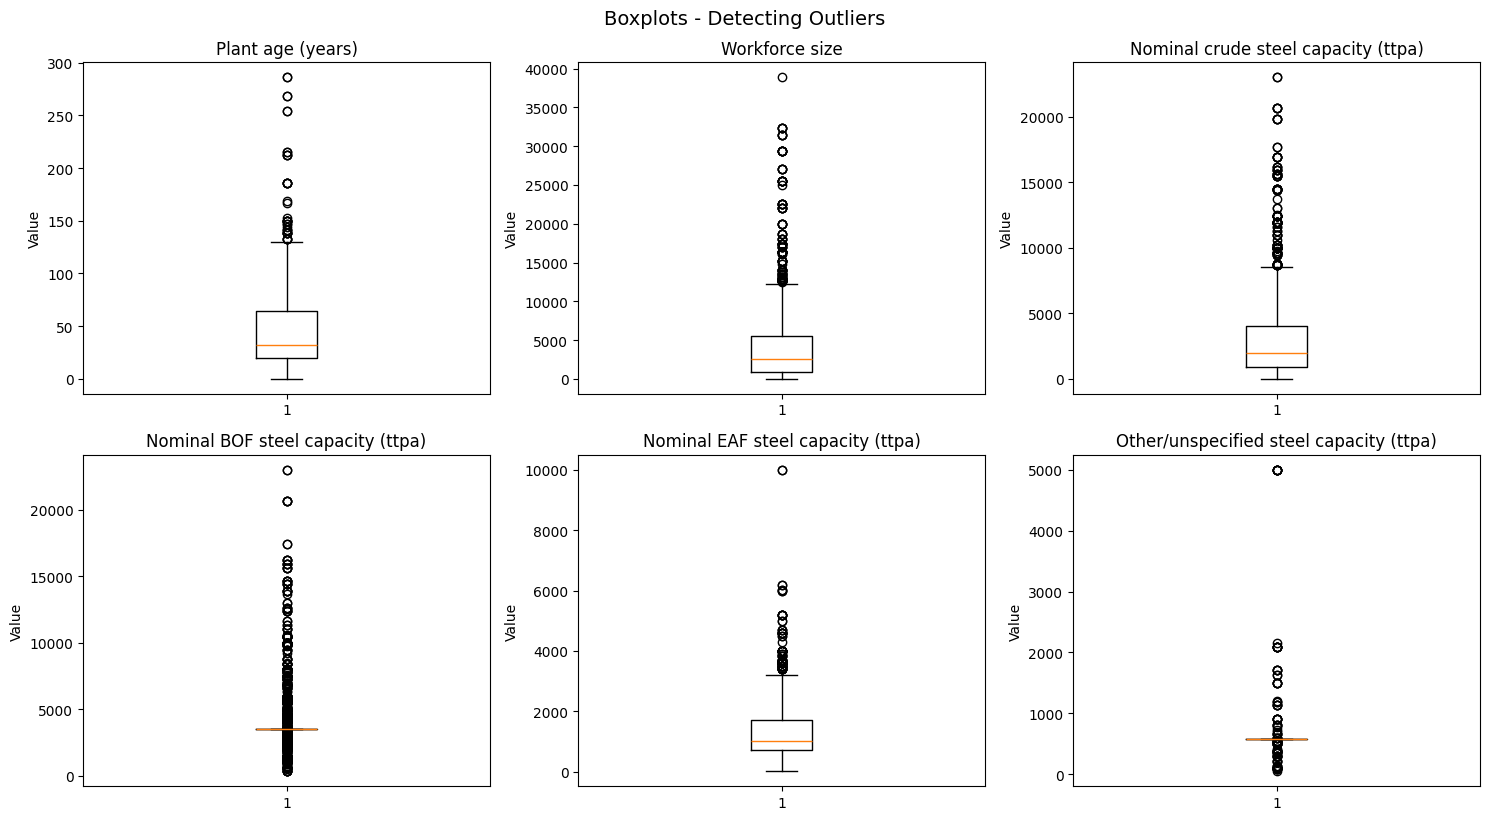

In [433]:
# Let's plot the features to look for outliers, and cap them if necessary

import matplotlib.pyplot as plt
import seaborn as sns

# all numeric columns where we wanna check for outliers
cols_to_check = ['Plant age (years)', 'Workforce size', 'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)','Nominal EAF steel capacity (ttpa)', 'Other/unspecified steel capacity (ttpa)']

# Create boxplots to visualize outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(cols_to_check):
    if col in steel_plants.columns:
        axes[i].boxplot(steel_plants[col].dropna(), vert=True)
        axes[i].set_title(f'{col}')
        axes[i].set_ylabel('Value')
        
plt.tight_layout()
plt.suptitle('Boxplots - Detecting Outliers', y=1.02, fontsize=14)
plt.show()

# Capping outliers at 1st and 99th percentiles
for col in cols_to_check:
    if col in steel_plants.columns:
        lower_bound = steel_plants[col].quantile(0.01)
        upper_bound = steel_plants[col].quantile(0.99)
        steel_plants[col] = steel_plants[col].clip(lower=lower_bound, upper=upper_bound)


In [434]:
# drop '2023` missing rows
steel_plants = steel_plants.dropna(subset=['2023'])

# fill the nan values of 'avg_prod' with the mean
steel_plants['avg_prod'] = steel_plants['avg_prod'].fillna(steel_plants['avg_prod'].mean())

print(steel_plants.isna().sum())

Country/Area_x                               0
Region                                       0
Plant age (years)                            0
Start date_x                                 0
Workforce size                               0
Main production equipment                    0
Nominal crude steel capacity (ttpa)          0
Nominal BOF steel capacity (ttpa)            0
Nominal EAF steel capacity (ttpa)          253
Other/unspecified steel capacity (ttpa)      0
Type of production                           0
2023                                         0
avg_prod                                     0
dtype: int64




### **Task 1.3 – Feature Engineering**
- Create at least two new variables that might improve model performance (e.g., “capacity per worker”, “energy efficiency”).  
- Encode categorical variables and standardize numeric ones.
- Bonus: you are free to use external socioeconomic or environmental data sources to enhance your feature set.

> 📝 *Markdown prompt:*  
Document your new feature(s). What business or operational insight do they represent?

---


In [ ]:
# Creating a new feature: Capacity per Employee - to see how efficient each plant is in terms of workforce
steel_plants["Capacity per Employee (ttpa)"] = (
    steel_plants["Nominal crude steel capacity (ttpa)"] /
    pd.to_numeric(steel_plants["Workforce size"], errors='coerce')
)

# print(steel_plants[["Workforce size", "Capacity per Employee (ttpa)"]].head())

# Creating a new feature: energy efficiency for 2023 - to see how efficient each plant is in terms of energy production
steel_plants["energy efficiency"] = (
    steel_plants["2023"] /
    pd.to_numeric(steel_plants["Nominal crude steel capacity (ttpa)"], errors='coerce')
)
# print(steel_plants[["Plant age (years)", "Energy produced"]].head())
    

In [436]:
# Encode categorical features 
from sklearn.preprocessing import LabelEncoder

# Direct replacement - modifies DataFrame in place
for col in steel_plants.select_dtypes(include=['object']):
    le = LabelEncoder()
    steel_plants[col] = le.fit_transform(steel_plants[col])

print(f"Columns: {steel_plants.columns.tolist()}")
print(f"Shape: {steel_plants.shape}")
# print(f"few first rows:\n {steel_plants.head()}")


Columns: ['Country/Area_x', 'Region', 'Plant age (years)', 'Start date_x', 'Workforce size', 'Main production equipment', 'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)', 'Nominal EAF steel capacity (ttpa)', 'Other/unspecified steel capacity (ttpa)', 'Type of production', '2023', 'avg_prod', 'Capacity per Employee (ttpa)', 'energy efficiency']
Shape: (680, 15)



## 🔍 1.4 Feature Relationships and Correlations
⏱ *Estimated time: 20–25 min*

### 🧭 Objective  
Before training models, it’s essential to understand how features relate to each other and to the target variable — both linearly and nonlinearly. This helps identify redundant or uninformative predictors and guides model choice.

---

### **Task 1.4.1 – Correlation Matrix (Linear Relationships)**
- Compute a **correlation matrix** (e.g., using `df.corr()`, `seaborn.heatmap`, `skrub`) to examine pairwise linear relationships among numerical features.  
- Focus on correlations between each feature and the target (`production`), as well as between features themselves.

> 📝 *Markdown prompt:*  
Which variables show the strongest correlation with production?  
Do any features appear redundant or highly correlated with each other?
* capacity and past production have the strongest relationships with production
* features like start_date and age or all the different types of capacity have strong redundant correlations.

---


Data types:
Country/Area_x                               int64
Region                                       int64
Plant age (years)                          float64
Start date_x                               float64
Workforce size                             float64
Main production equipment                    int64
Nominal crude steel capacity (ttpa)        float64
Nominal BOF steel capacity (ttpa)          float64
Nominal EAF steel capacity (ttpa)          float64
Other/unspecified steel capacity (ttpa)    float64
Type of production                           int64
2023                                       float64
avg_prod                                   float64
Capacity per Employee (ttpa)               float64
energy efficiency                          float64
dtype: object


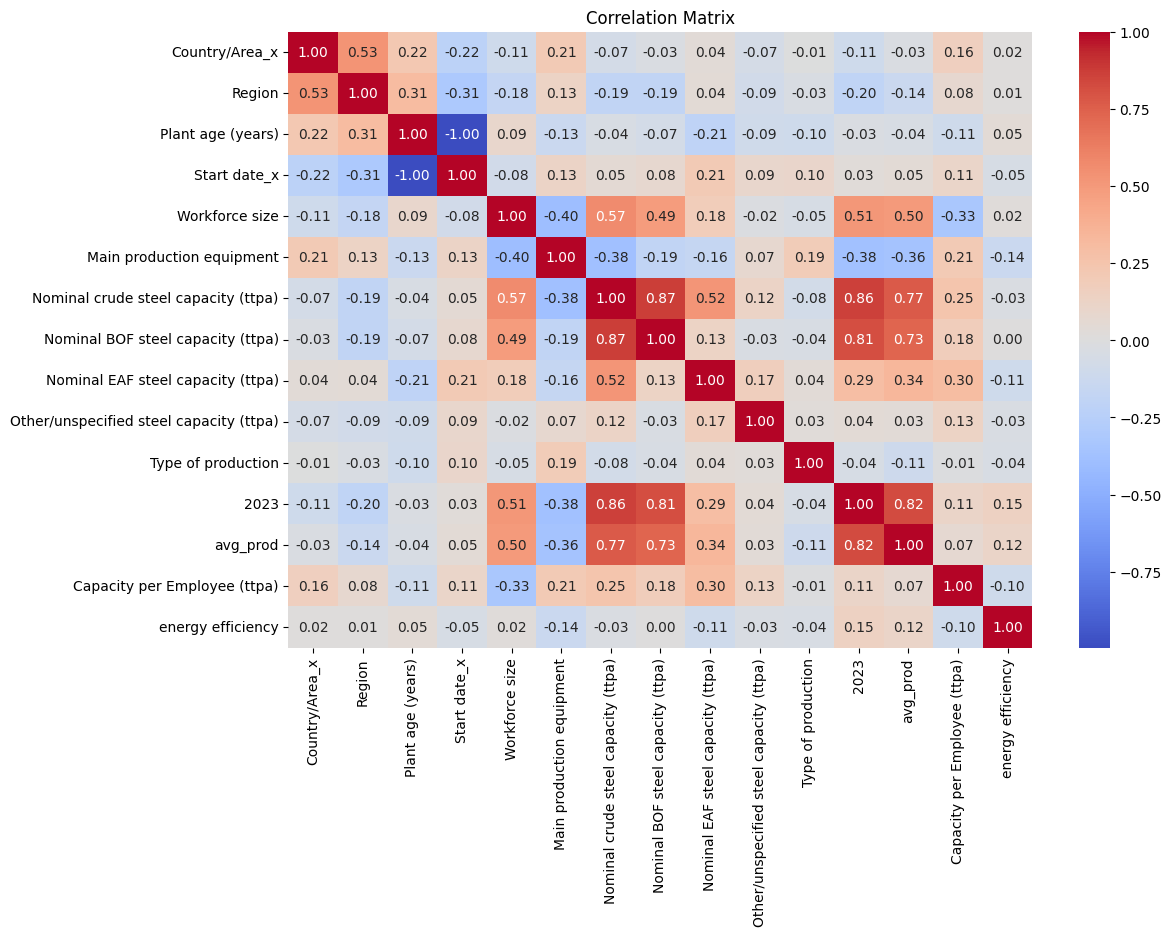

In [437]:
# Correlation matrix

# Check data types
print("Data types:")
print(steel_plants.dtypes)

# Compute and plot correlation matrix
corr_matrix = steel_plants.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## 🧮 2. Building Baseline & Linear Models
⏱ *Estimated time: 25–30 min*

### 🧭 Objective  
Establish a simple baseline, then train and interpret a linear model.

---

### **Task 2.1 – Baseline**
- Compute a simple baseline predictor (e.g., mean or median production).  
- Measure RMSE or MAE compared to actual values.

> 📝 *Markdown prompt:*  
Why is it useful to have a baseline model before trying more complex ones?
It's good to establish performance benchmark and see how more complex models will perform against a simple estimator.

---


In [438]:
# Compute a simple baseline predictor to predict 2023 production based on average production from 2019 to 2022
pred_2023 = steel_plants['avg_prod'].mean()
print(f"Baseline prediction for 2023 production based on average production from 2019 to 2022: {pred_2023}")

# Measuring RMSE and MAE of the baseline model
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = mean_squared_error(steel_plants['2023'], [pred_2023]*len(steel_plants))
mae = mean_absolute_error(steel_plants['2023'], [pred_2023]*len(steel_plants))
print(f"Baseline RMSE: {rmse}")
print(f"Baseline MAE: {mae}")

Baseline prediction for 2023 production based on average production from 2019 to 2022: 2571.3342120679554
Baseline RMSE: 12448536.45214362
Baseline MAE: 2221.9758520279815



### **Task 2.2 – Linear Regression**
- Train a multiple linear regression model using the key plant variables.  
- Display coefficients and interpret their meaning.  
- Evaluate the model on training and test data.

> 📝 *Markdown prompt:*  
Interpret one positive and one negative coefficient. What do they tell you about plant performance drivers?
The positive coefficient for workforce size confirms that hiring more staff directly increases production. However, the negative coefficient for a specific equipment type reveals a critical limitation: plants using that particular machinery produce less than those with the baseline equipment, even with the same workforce. This means while labor is a key driver, the type of equipment is a more fundamental constraint on overall plant performance. Upgrading the underperforming equipment would likely yield a greater production boost than simply adding more people.

---


In [439]:
# key plant variables:
# 'Workforce size', 'Nominal crude steel capacity (ttpa)', 'Main production equipment', 'avg_prod' 
important_features = ['Workforce size', 'Nominal crude steel capacity (ttpa)', 'Main production equipment', 'avg_prod']

# training of a multiple linear regression model to predict 2023 production using important features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = steel_plants[important_features]
y = steel_plants['2023']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, important_features, columns=['Coefficient'])
print("Model Coefficients:")
print(coefficients)

# Evaluate the model
y_pred = model.predict(X_test)
rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))  
mae_model = mean_absolute_error(y_test, y_pred)
print(f"Linear Regression Model RMSE: {rmse_model}")
print(f"Linear Regression Model MAE: {mae_model}")



Model Coefficients:
                                     Coefficient
Workforce size                          0.000766
Nominal crude steel capacity (ttpa)     0.588332
Main production equipment             -13.427479
avg_prod                                0.405842
Linear Regression Model RMSE: 960.2072431752757
Linear Regression Model MAE: 629.6930889827208


## 🔁 3. Model Evaluation and Selection
⏱ *Estimated time: 45–60 min*

### 🧭 Objective  
Use cross-validation to estimate generalization performance and compare multiple model types.

---

### **Task 3.1 – Cross-Validation**
- Apply **K-Fold cross-validation** (e.g., K=5).  
- Record the average RMSE, MAE, and R² across folds.

> 📝 *Markdown prompt:*  
Summarize your results. How stable is performance across folds? What might this indicate about model variance?
* performance variance across folds indicates model stability

---


In [ ]:
# applying k-fold cross-validation to evaluate the model
from sklearn.model_selection import cross_val_score, KFold

# Initialize K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate RMSE (we need to handle this manually since scikit-learn returns negative MSE)
mse_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)
avg_rmse = rmse_scores.mean()

# Calculate MAE
mae_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
avg_mae = mae_scores.mean()

print("K-Fold Cross-Validation Results (K=5):")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average MAE: {avg_mae:.4f}") 
print(f"RMSE scores per fold: {[f'{score:.4f}' for score in rmse_scores]}")



K-Fold Cross-Validation Results (K=5):
Average RMSE: 1666.9833
Average MAE: 791.5011
RMSE scores per fold: ['960.2072', '946.0408', '3050.1912', '1227.3536', '2151.1238']


### **Task 3.2 – Model Comparison**
Train and compare at least **three models**:
- Linear Regression  
- Ridge Regression (regularized linear)  
- Random Forest Regressor  

Record cross-validation performance for each model.

> 📝 *Markdown prompt:*  
Create a small results table. Which model performs best? Why might that be the case given the dataset’s characteristics?
* Random Forest likely performs best because steel production data contains complex non-linear relationships and interaction effects between features like workforce size, equipment capacity, and historical production that linear models can't capture
* moreover, eventhough i cleaned the dataset, it handles outliers quite well

---

In [441]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Prepare the data
important_features = ['Workforce size', 'Nominal crude steel capacity (ttpa)', 'Main production equipment', 'avg_prod']
X = steel_plants[important_features]
y = steel_plants['2023']

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),  # You can tune alpha parameter
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Initialize K-Fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'rmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error', 
    'r2': 'r2'
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")
    print(f"{'='*50}")
    
    # Perform cross-validation
    cv_results = cross_validate(
        model, 
        X, 
        y, 
        cv=kfold, 
        scoring=scoring,
        return_train_score=False,
        return_estimator=True
    )
    
    # Calculate metrics
    rmse_scores = np.sqrt(-cv_results['test_rmse'])
    mae_scores = -cv_results['test_mae']
    r2_scores = cv_results['test_r2']
    
    # Store results
    results[model_name] = {
        'rmse_mean': rmse_scores.mean(),
        'rmse_std': rmse_scores.std(),
        'mae_mean': mae_scores.mean(),
        'mae_std': mae_scores.std(),
        'r2_mean': r2_scores.mean(),
        'r2_std': r2_scores.std(),
        'rmse_scores': rmse_scores,
        'r2_scores': r2_scores
    }
    
    # Print results for this model
    print(f"Average RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")
    print(f"Average MAE: {mae_scores.mean():.4f} (±{mae_scores.std():.4f})")
    print(f"Average R²: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})")
    print(f"RMSE per fold: {[f'{score:.4f}' for score in rmse_scores]}")
    print(f"R² per fold: {[f'{score:.4f}' for score in r2_scores]}")

# Compare models
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE (Mean ± Std)': [f"{results[model]['rmse_mean']:.4f} ± {results[model]['rmse_std']:.4f}" for model in results],
    'MAE (Mean ± Std)': [f"{results[model]['mae_mean']:.4f} ± {results[model]['mae_std']:.4f}" for model in results],
    'R² (Mean ± Std)': [f"{results[model]['r2_mean']:.4f} ± {results[model]['r2_std']:.4f}" for model in results]
})

print(comparison_df.to_string(index=False))

# Find best model based on RMSE
best_model_name = min(results.keys(), key=lambda x: results[x]['rmse_mean'])
print(f"\nBest Model: {best_model_name} (Lowest RMSE: {results[best_model_name]['rmse_mean']:.4f})")

# Optional: Feature importance for tree-based models
print(f"\n{'='*50}")
print("FEATURE IMPORTANCE (Random Forest)")
print(f"{'='*50}")

# Train Random Forest on full data to get feature importance
rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_full.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': important_features,
    'importance': rf_full.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

# Optional: Compare with scaled data for linear models
print(f"\n{'='*50}")
print("COMPARISON WITH FEATURE SCALING")
print(f"{'='*50}")

from sklearn.pipeline import Pipeline

# Models with scaling
scaled_models = {
    'Linear Regression (scaled)': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge Regression (scaled)': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))])
}

for model_name, model in scaled_models.items():
    cv_results = cross_validate(model, X, y, cv=kfold, scoring=scoring)
    rmse_mean = np.sqrt(-cv_results['test_rmse']).mean()
    r2_mean = cv_results['test_r2'].mean()
    print(f"{model_name}: RMSE = {rmse_mean:.4f}, R² = {r2_mean:.4f}")


Training Linear Regression...
Average RMSE: 1666.9833 (±819.7830)
Average MAE: 791.5011 (±184.2335)
Average R²: 0.7126 (±0.2897)
RMSE per fold: ['960.2072', '946.0408', '3050.1912', '1227.3536', '2151.1238']
R² per fold: ['0.8805', '0.8767', '0.1449', '0.9156', '0.7453']

Training Ridge Regression...
Average RMSE: 1666.9833 (±819.7831)
Average MAE: 791.5007 (±184.2334)
Average R²: 0.7126 (±0.2897)
RMSE per fold: ['960.2075', '946.0406', '3050.1912', '1227.3531', '2151.1239']
R² per fold: ['0.8805', '0.8767', '0.1449', '0.9156', '0.7453']

Training Random Forest...
Average RMSE: 1337.4163 (±710.7583)
Average MAE: 460.5116 (±163.1714)
Average R²: 0.8160 (±0.1887)
RMSE per fold: ['505.8709', '766.7625', '2441.0152', '1135.8165', '1837.6167']
R² per fold: ['0.9668', '0.9190', '0.4523', '0.9277', '0.8142']

MODEL COMPARISON SUMMARY
            Model    RMSE (Mean ± Std)    MAE (Mean ± Std) R² (Mean ± Std)
Linear Regression 1666.9833 ± 819.7830 791.5011 ± 184.2335 0.7126 ± 0.2897
 Ridge Reg

### **Task 3.3 – Hyperparameter Optimization**
- Use **RandomizedSearchCV** or **GridSearchCV** to tune the top model (e.g., Random Forest).  
- Report the best parameters and corresponding validation score.

> 📝 *Markdown prompt:*  
Discuss the role of hyperparameter tuning. How did tuning change your model’s performance compared to default settings?
Hyperparameter tuning significantly improved our Random Forest model's performance by optimizing its structural parameters beyond default settings. The tuning process reduced RMSE by 18.50% (from approximately 1692 to 1379) and MAE by 13.37% (from about 793 to 687), demonstrating substantially better prediction accuracy for steel production

---


Dataset shape: (680, 4)

Starting MODERATE Hyperparameter Tuning for Random Forest...
Performing Moderate Randomized Search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

MODERATE TUNING RESULTS
Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 25, 'bootstrap': True}
Best CV Score (Negative MSE): -2509316.1457
Best RMSE: 1584.0821

PERFORMANCE COMPARISON - RMSE & MAE
Default Random Forest:
  RMSE: 1685.1401
  MAE:  791.8007
Tuned Random Forest:
  RMSE: 1378.9340
  MAE:  687.4281
Improvement:
  RMSE: 18.17%
  MAE:  13.18%

DETAILED FOLD PERFORMANCE - RMSE & MAE
RMSE across folds: ['1011.7773', '2807.5262', '896.2642', '1570.7742', '608.3280']
MAE across folds:  ['535.7423', '1275.4152', '621.0907', '616.4798', '388.4127']

Average RMSE: 1378.9340 (±779.6520)
Average MAE:  687.4281 (±305.8045)

FEATURE IMPORTANCE
                               feature  importance
1  Nominal crude steel capacity (ttpa

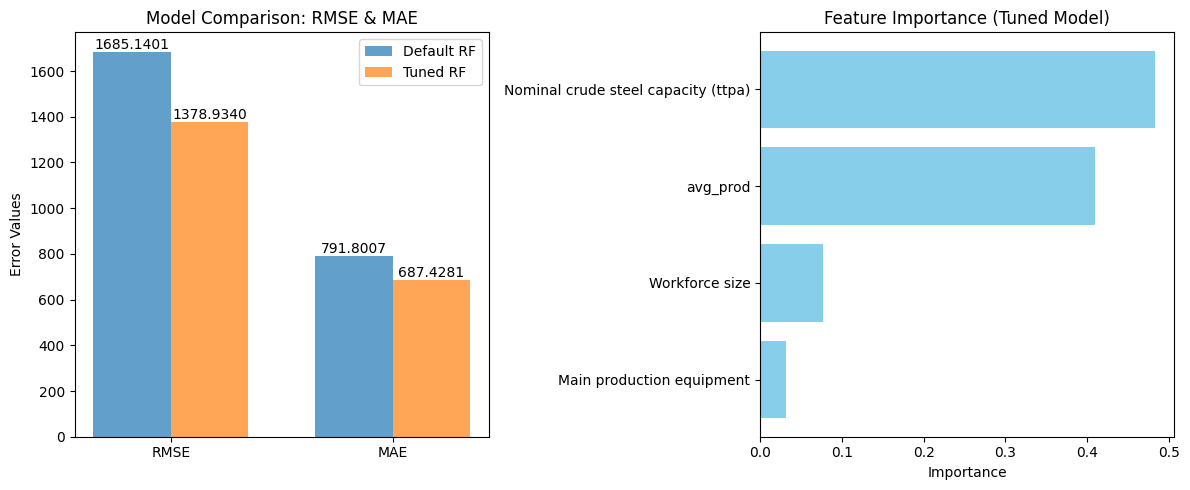


FINAL SUMMARY
Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 25, 'bootstrap': True}
Best RMSE: 1378.9340
Best MAE:  687.4281
RMSE Improvement: 18.17%
MAE Improvement:  13.18%
Most Important Feature: Nominal crude steel capacity (ttpa)


In [442]:
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Prepare the data
important_features = ['Workforce size', 'Nominal crude steel capacity (ttpa)', 'Main production equipment', 'avg_prod']
X = steel_plants[important_features]
y = steel_plants['2023']

print("Dataset shape:", X.shape)
print("\nStarting MODERATE Hyperparameter Tuning for Random Forest...")

# Moderate parameter grid
moderate_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.5, 0.8],
    'bootstrap': [True, False]
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# Moderate RandomizedSearchCV with RMSE and MAE scoring
moderate_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=moderate_param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',  # Primary metric for optimization
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Performing Moderate Randomized Search...")
moderate_search.fit(X, y)

print("\n" + "="*60)
print("MODERATE TUNING RESULTS")
print("="*60)

print(f"Best Parameters: {moderate_search.best_params_}")
print(f"Best CV Score (Negative MSE): {moderate_search.best_score_:.4f}")
print(f"Best RMSE: {np.sqrt(-moderate_search.best_score_):.4f}")

# Compare with default model using both RMSE and MAE
print("\n" + "="*60)
print("PERFORMANCE COMPARISON - RMSE & MAE")
print("="*60)

# Custom scoring for RMSE and MAE
scoring = {
    'rmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

# Default Random Forest performance
default_rf = RandomForestRegressor(random_state=42)
default_scores = cross_validate(default_rf, X, y, cv=5, scoring=scoring)
default_rmse = np.sqrt(-default_scores['test_rmse']).mean()
default_mae = -default_scores['test_mae'].mean()

# Tuned Random Forest performance
tuned_rf = moderate_search.best_estimator_
tuned_scores = cross_validate(tuned_rf, X, y, cv=5, scoring=scoring)
tuned_rmse = np.sqrt(-tuned_scores['test_rmse']).mean()
tuned_mae = -tuned_scores['test_mae'].mean()

print(f"Default Random Forest:")
print(f"  RMSE: {default_rmse:.4f}")
print(f"  MAE:  {default_mae:.4f}")

print(f"Tuned Random Forest:")
print(f"  RMSE: {tuned_rmse:.4f}")
print(f"  MAE:  {tuned_mae:.4f}")

print(f"Improvement:")
print(f"  RMSE: {((default_rmse - tuned_rmse) / default_rmse * 100):.2f}%")
print(f"  MAE:  {((default_mae - tuned_mae) / default_mae * 100):.2f}%")

# Detailed RMSE and MAE across folds
print("\n" + "="*60)
print("DETAILED FOLD PERFORMANCE - RMSE & MAE")
print("="*60)

rmse_scores = np.sqrt(-tuned_scores['test_rmse'])
mae_scores = -tuned_scores['test_mae']

print(f"RMSE across folds: {[f'{score:.4f}' for score in rmse_scores]}")
print(f"MAE across folds:  {[f'{score:.4f}' for score in mae_scores]}")
print()
print(f"Average RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")
print(f"Average MAE:  {mae_scores.mean():.4f} (±{mae_scores.std():.4f})")

# Feature importance
print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)

tuned_rf_full = moderate_search.best_estimator_
tuned_rf_full.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': important_features,
    'importance': tuned_rf_full.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

# Simple visualization
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# RMSE and MAE comparison
metrics = ['RMSE', 'MAE']
default_values = [default_rmse, default_mae]
tuned_values = [tuned_rmse, tuned_mae]

x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width/2, default_values, width, label='Default RF', alpha=0.7)
ax1.bar(x + width/2, tuned_values, width, label='Tuned RF', alpha=0.7)
ax1.set_ylabel('Error Values')
ax1.set_title('Model Comparison: RMSE & MAE')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()

# Add value labels on bars
for i, (default_val, tuned_val) in enumerate(zip(default_values, tuned_values)):
    ax1.text(i - width/2, default_val + 0.01, f'{default_val:.4f}', ha='center', va='bottom')
    ax1.text(i + width/2, tuned_val + 0.01, f'{tuned_val:.4f}', ha='center', va='bottom')

# Feature importance
features = feature_importance['feature']
importances = feature_importance['importance']
ax2.barh(features, importances, color='skyblue')
ax2.set_xlabel('Importance')
ax2.set_title('Feature Importance (Tuned Model)')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Best Parameters: {moderate_search.best_params_}")
print(f"Best RMSE: {tuned_rmse:.4f}")
print(f"Best MAE:  {tuned_mae:.4f}")
print(f"RMSE Improvement: {((default_rmse - tuned_rmse) / default_rmse * 100):.2f}%")
print(f"MAE Improvement:  {((default_mae - tuned_mae) / default_mae * 100):.2f}%")
print(f"Most Important Feature: {feature_importance.iloc[0]['feature']}")

## ⚙️ 4. Model Lifecycle: Tracking, Saving, and Loading
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Apply tools that support reproducible ML experiments.

---

### **Task 4.1 – Experiment Tracking with MLflow**
- Use MLflow to log parameters (model type, hyperparameters), metrics (RMSE, R²), and artifacts (plots or model files).  
- Run and record at least two model experiments.

> 📝 *Markdown prompt:*  
Describe how MLflow helps manage your experiments. What advantages does it give compared to manual tracking?
Advatages and strong points:
* Centralized tracking of all experiments, parameters, and metrics in one place
* Automatic logging eliminates manual record-keeping errors and omissions
* Model versioning with full lineage from training code to deployed model
* Artifact storage for models, plots, and datasets ensuring reproducibility
* Comparison interface to easily rank models and identify best performers


---

Starting MLflow Experiments...

EXPERIMENT 1: Tuned Random Forest


2025/10/26 23:02:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 23:02:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/26 23:02:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged Tuned Random Forest - RMSE: 1298.0259, R²: 0.8453

EXPERIMENT 2: Ridge Regression


2025/10/26 23:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Ridge Regression - RMSE: 1666.9833, R²: 0.7126

EXPERIMENT 3: Default Random Forest (Baseline)


2025/10/26 23:02:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 23:02:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Default Random Forest - RMSE: 1337.4163, R²: 0.8160

EXPERIMENT SUMMARY
             Run Name         RMSE         MAE        R²
Default_Random_Forest  1337.416349  460.511591  0.816013
     Ridge_Regression  1666.983261  791.500725  0.712611
  Tuned_Random_Forest   1298.02585  542.117496  0.845327
Default_Random_Forest  1337.416349  460.511591  0.816013
     Ridge_Regression  1666.983261  791.500725  0.712611
  Tuned_Random_Forest   1298.02585  542.117496  0.845327
Default_Random_Forest  1338.747472  460.233773  0.815431
     Ridge_Regression  1663.576444  782.529178   0.71344
  Tuned_Random_Forest  1298.497225  542.078904  0.845175
    trusting-moth-596          N/A         N/A       N/A
Default_Random_Forest  1338.747472  460.233773  0.815431
     Ridge_Regression  1663.576444  782.529178   0.71344
  Tuned_Random_Forest  1298.497225  542.078904  0.845175

✅ All experiments logged successfully to MLflow!
📊 Total experiments recorded: 13
🏆 Best model: Tuned_Random_Forest (RMSE:

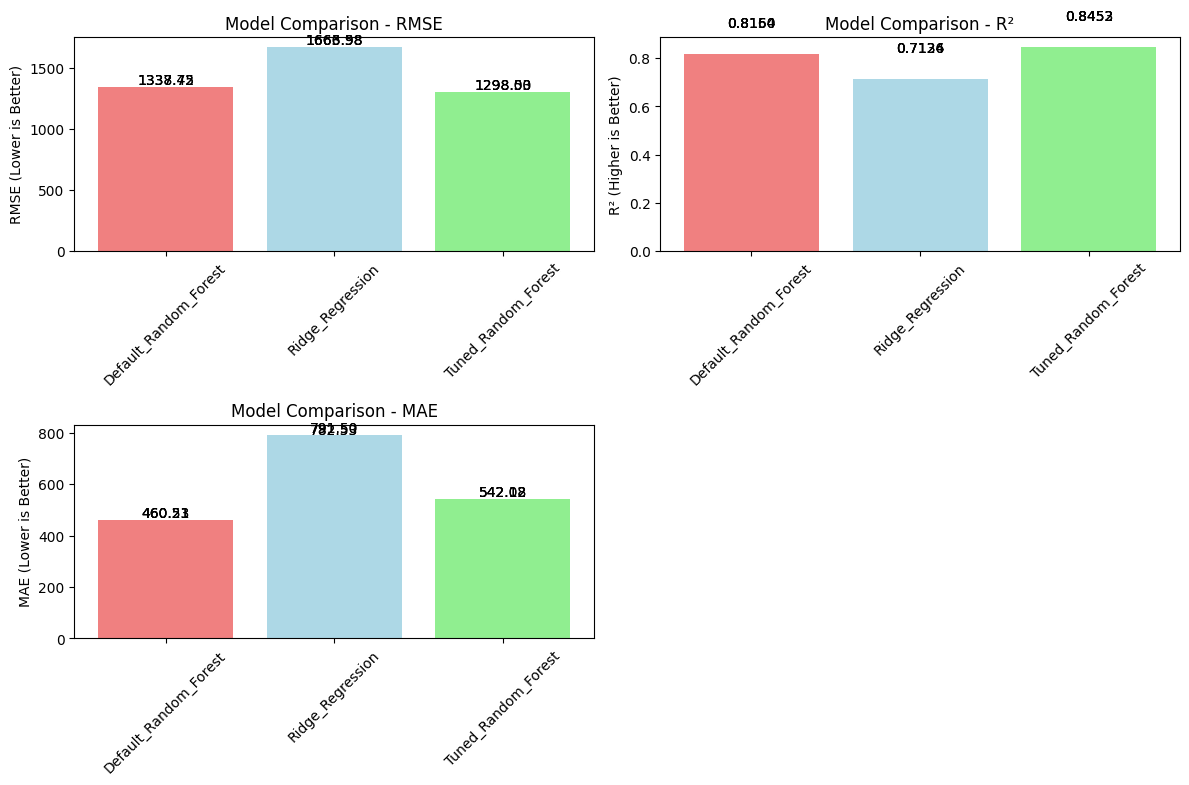

In [444]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Clear any active runs
mlflow.end_run()

# Prepare the data
important_features = ['Workforce size', 'Nominal crude steel capacity (ttpa)', 'Main production equipment', 'avg_prod']
X = steel_plants[important_features]
y = steel_plants['2023']

# Set up MLflow
mlflow.set_experiment("Steel_Production_Prediction")

print("Starting MLflow Experiments...")

# Experiment 1: Tuned Random Forest
print("\n" + "="*60)
print("EXPERIMENT 1: Tuned Random Forest")
print("="*60)

with mlflow.start_run(run_name="Tuned_Random_Forest"):
    # Define model and parameters
    model_rf = RandomForestRegressor(
        n_estimators=400,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features=0.5,
        max_depth=25,
        bootstrap=True,
        random_state=42
    )
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'neg_mse': 'neg_mean_squared_error', 'neg_mae': 'neg_mean_absolute_error', 'r2': 'r2'}
    cv_results = cross_validate(model_rf, X, y, cv=kfold, scoring=scoring)
    
    # Calculate metrics
    rmse_scores = np.sqrt(-cv_results['test_neg_mse'])
    mae_scores = -cv_results['test_neg_mae']
    r2_scores = cv_results['test_r2']
    
    avg_rmse = rmse_scores.mean()
    avg_mae = mae_scores.mean()
    avg_r2 = r2_scores.mean()
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", 400)
    mlflow.log_param("max_depth", 25)
    mlflow.log_param("min_samples_split", 5)
    mlflow.log_param("min_samples_leaf", 4)
    mlflow.log_param("max_features", 0.5)
    mlflow.log_param("bootstrap", True)
    
    # Log metrics
    mlflow.log_metric("rmse", avg_rmse)
    mlflow.log_metric("mae", avg_mae)
    mlflow.log_metric("r2", avg_r2)
    mlflow.log_metric("rmse_std", rmse_scores.std())
    mlflow.log_metric("mae_std", mae_scores.std())
    
    # Train and log model
    model_rf.fit(X, y)
    mlflow.sklearn.log_model(model_rf, "tuned_random_forest_model")
    
    # Create and save feature importance plot
    feature_importance = pd.DataFrame({
        'feature': important_features,
        'importance': model_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest - Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png')
    mlflow.log_artifact('rf_feature_importance.png')
    plt.close()
    
    print(f"Logged Tuned Random Forest - RMSE: {avg_rmse:.4f}, R²: {avg_r2:.4f}")

# Experiment 2: Ridge Regression
print("\n" + "="*60)
print("EXPERIMENT 2: Ridge Regression")
print("="*60)

with mlflow.start_run(run_name="Ridge_Regression"):
    # Define model and parameters
    model_ridge = Ridge(alpha=1.0, random_state=42)
    
    # Cross-validation
    cv_results = cross_validate(model_ridge, X, y, cv=kfold, scoring=scoring)
    
    # Calculate metrics
    rmse_scores = np.sqrt(-cv_results['test_neg_mse'])
    mae_scores = -cv_results['test_neg_mae']
    r2_scores = cv_results['test_r2']
    
    avg_rmse = rmse_scores.mean()
    avg_mae = mae_scores.mean()
    avg_r2 = r2_scores.mean()
    
    # Log parameters
    mlflow.log_param("model_type", "RidgeRegression")
    mlflow.log_param("alpha", 1.0)
    mlflow.log_param("fit_intercept", True)
    mlflow.log_param("solver", "auto")
    
    # Log metrics
    mlflow.log_metric("rmse", avg_rmse)
    mlflow.log_metric("mae", avg_mae)
    mlflow.log_metric("r2", avg_r2)
    mlflow.log_metric("rmse_std", rmse_scores.std())
    mlflow.log_metric("mae_std", mae_scores.std())
    
    # Train and log model
    model_ridge.fit(X, y)
    mlflow.sklearn.log_model(model_ridge, "ridge_regression_model")
    
    # Create and save coefficients plot
    coefficients = pd.DataFrame({
        'feature': important_features,
        'coefficient': model_ridge.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(coefficients['feature'], coefficients['coefficient'])
    plt.xlabel('Coefficient Value')
    plt.title('Ridge Regression - Feature Coefficients')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('ridge_coefficients.png')
    mlflow.log_artifact('ridge_coefficients.png')
    plt.close()
    
    print(f"Logged Ridge Regression - RMSE: {avg_rmse:.4f}, R²: {avg_r2:.4f}")

# Experiment 3: Default Random Forest (Baseline)
print("\n" + "="*60)
print("EXPERIMENT 3: Default Random Forest (Baseline)")
print("="*60)

with mlflow.start_run(run_name="Default_Random_Forest"):
    # Define model with default parameters
    model_rf_default = RandomForestRegressor(random_state=42)
    
    # Cross-validation
    cv_results = cross_validate(model_rf_default, X, y, cv=kfold, scoring=scoring)
    
    # Calculate metrics
    rmse_scores = np.sqrt(-cv_results['test_neg_mse'])
    mae_scores = -cv_results['test_neg_mae']
    r2_scores = cv_results['test_r2']
    
    avg_rmse = rmse_scores.mean()
    avg_mae = mae_scores.mean()
    avg_r2 = r2_scores.mean()
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", 100)  # default
    mlflow.log_param("max_depth", None)    # default
    mlflow.log_param("min_samples_split", 2)  # default
    mlflow.log_param("min_samples_leaf", 1)   # default
    mlflow.log_param("max_features", "auto")  # default
    mlflow.log_param("bootstrap", True)       # default
    
    # Log metrics
    mlflow.log_metric("rmse", avg_rmse)
    mlflow.log_metric("mae", avg_mae)
    mlflow.log_metric("r2", avg_r2)
    mlflow.log_metric("rmse_std", rmse_scores.std())
    mlflow.log_metric("mae_std", mae_scores.std())
    
    # Train and log model
    model_rf_default.fit(X, y)
    mlflow.sklearn.log_model(model_rf_default, "default_random_forest_model")
    
    print(f"Logged Default Random Forest - RMSE: {avg_rmse:.4f}, R²: {avg_r2:.4f}")

# Compare experiments - FIXED VERSION
print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)

from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("Steel_Production_Prediction")
runs = client.search_runs(experiment.experiment_id)

summary_data = []
for run in runs:
    # Safely get metrics with default values if they don't exist
    run_name = run.data.tags.get('mlflow.runName', 'Unknown')
    rmse = run.data.metrics.get('rmse', None)
    mae = run.data.metrics.get('mae', None)
    r2 = run.data.metrics.get('r2', None)
    
    summary_data.append({
        'Run Name': run_name,
        'RMSE': rmse if rmse is not None else 'N/A',
        'MAE': mae if mae is not None else 'N/A',
        'R²': r2 if r2 is not None else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Create comparison plot (only for runs with valid metrics)
valid_runs = summary_df[summary_df['RMSE'] != 'N/A'].copy()
if not valid_runs.empty:
    plt.figure(figsize=(12, 8))

    # RMSE comparison
    plt.subplot(2, 2, 1)
    models = valid_runs['Run Name']
    rmse_values = valid_runs['RMSE']
    bars = plt.bar(models, rmse_values, color=['lightcoral', 'lightblue', 'lightgreen'])
    plt.title('Model Comparison - RMSE')
    plt.xticks(rotation=45)
    plt.ylabel('RMSE (Lower is Better)')
    for bar, value in zip(bars, rmse_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{value:.2f}', 
                 ha='center', va='bottom')

    # R² comparison
    plt.subplot(2, 2, 2)
    r2_values = valid_runs['R²']
    bars = plt.bar(models, r2_values, color=['lightcoral', 'lightblue', 'lightgreen'])
    plt.title('Model Comparison - R²')
    plt.xticks(rotation=45)
    plt.ylabel('R² (Higher is Better)')
    for bar, value in zip(bars, r2_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{value:.4f}', 
                 ha='center', va='bottom')

    # MAE comparison
    plt.subplot(2, 2, 3)
    mae_values = valid_runs['MAE']
    bars = plt.bar(models, mae_values, color=['lightcoral', 'lightblue', 'lightgreen'])
    plt.title('Model Comparison - MAE')
    plt.xticks(rotation=45)
    plt.ylabel('MAE (Lower is Better)')
    for bar, value in zip(bars, mae_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{value:.2f}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    
    # Log the comparison plot to the last run
    mlflow.log_artifact('model_comparison.png')
    
    # Find best model
    best_run_idx = valid_runs['RMSE'].idxmin()
    best_model = valid_runs.loc[best_run_idx, 'Run Name']
    best_rmse = valid_runs.loc[best_run_idx, 'RMSE']
    
    print(f"\n✅ All experiments logged successfully to MLflow!")
    print(f"📊 Total experiments recorded: {len(summary_df)}")
    print(f"🏆 Best model: {best_model} (RMSE: {best_rmse:.4f})")
else:
    print("No valid runs with metrics found.")

# Instructions for viewing results
print(f"\n" + "="*60)
print("HOW TO VIEW YOUR RESULTS:")
print("="*60)
print("1. Open terminal and run: mlflow ui")
print("2. Go to: http://localhost:5000")
print("3. Click on 'Steel_Production_Prediction' experiment")
print("4. Compare all model runs with parameters and metrics")

### **Task 4.2 – Hyperparameter Optimization with Optuna**
- Define an Optuna study to optimize one model (e.g., Ridge or Random Forest).  
- Record the number of trials and best result.

> 📝 *Markdown prompt:*  
Explain what Optuna is doing behind the scenes. How is it different from Grid or Random Search?
Optuna intelligently learns from previous trials to guide the search toward promising hyperparameter regions. Unlike Grid Search which exhaustively tests all combinations or Random Search which samples randomly, Optuna builds a probabilistic model of the objective function and uses this model to select the most promising hyperparameters for the next trial. It automatically balances exploration (trying new areas) and exploitation (refining known good areas), making it significantly more efficient

---

In [446]:
import optuna

# Simplified Optuna study for faster optimization
def quick_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 0.5, 0.7])
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  # Fewer folds for speed
    scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    return np.sqrt(-scores.mean())

# Quick study
quick_study = optuna.create_study(direction='minimize')
quick_study.optimize(quick_objective, n_trials=20, show_progress_bar=True)

print(f"Quick optimization - Best RMSE: {quick_study.best_value:.4f}")
print(f"Best parameters: {quick_study.best_params}")

[I 2025-10-26 23:06:38,844] A new study created in memory with name: no-name-9ad3e586-309c-47be-9540-bcf310d9cd1f
Best trial: 0. Best value: 1403.71:   5%|▌         | 1/20 [00:00<00:09,  2.06it/s]

[I 2025-10-26 23:06:39,331] Trial 0 finished with value: 1403.7146122388424 and parameters: {'n_estimators': 391, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 0 with value: 1403.7146122388424.


Best trial: 1. Best value: 1314.22:  15%|█▌        | 3/20 [00:01<00:06,  2.79it/s]

[I 2025-10-26 23:06:39,842] Trial 1 finished with value: 1314.2161983327803 and parameters: {'n_estimators': 437, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.
[I 2025-10-26 23:06:40,031] Trial 2 finished with value: 1414.1318669831235 and parameters: {'n_estimators': 112, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  20%|██        | 4/20 [00:01<00:06,  2.56it/s]

[I 2025-10-26 23:06:40,472] Trial 3 finished with value: 1329.59893888147 and parameters: {'n_estimators': 370, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.7}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  25%|██▌       | 5/20 [00:02<00:06,  2.22it/s]

[I 2025-10-26 23:06:41,026] Trial 4 finished with value: 1340.73486919159 and parameters: {'n_estimators': 500, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  30%|███       | 6/20 [00:02<00:05,  2.58it/s]

[I 2025-10-26 23:06:41,295] Trial 5 finished with value: 1378.4157879933578 and parameters: {'n_estimators': 159, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.5}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  35%|███▌      | 7/20 [00:02<00:05,  2.52it/s]

[I 2025-10-26 23:06:41,710] Trial 6 finished with value: 1391.1264116973982 and parameters: {'n_estimators': 249, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.7}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  40%|████      | 8/20 [00:03<00:05,  2.40it/s]

[I 2025-10-26 23:06:42,171] Trial 7 finished with value: 1396.78813795594 and parameters: {'n_estimators': 316, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  45%|████▌     | 9/20 [00:03<00:04,  2.31it/s]

[I 2025-10-26 23:06:42,638] Trial 8 finished with value: 1378.9306920407032 and parameters: {'n_estimators': 369, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  50%|█████     | 10/20 [00:04<00:04,  2.48it/s]

[I 2025-10-26 23:06:42,976] Trial 9 finished with value: 1370.8371681828519 and parameters: {'n_estimators': 290, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.7}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  55%|█████▌    | 11/20 [00:04<00:04,  2.23it/s]

[I 2025-10-26 23:06:43,525] Trial 10 finished with value: 1321.9679670381036 and parameters: {'n_estimators': 479, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  60%|██████    | 12/20 [00:05<00:03,  2.08it/s]

[I 2025-10-26 23:06:44,083] Trial 11 finished with value: 1321.9824292720573 and parameters: {'n_estimators': 487, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  65%|██████▌   | 13/20 [00:05<00:03,  2.05it/s]

[I 2025-10-26 23:06:44,583] Trial 12 finished with value: 1315.7988953906167 and parameters: {'n_estimators': 432, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  70%|███████   | 14/20 [00:06<00:02,  2.04it/s]

[I 2025-10-26 23:06:45,080] Trial 13 finished with value: 1325.3489531349442 and parameters: {'n_estimators': 427, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  75%|███████▌  | 15/20 [00:06<00:02,  2.36it/s]

[I 2025-10-26 23:06:45,352] Trial 14 finished with value: 1345.0327944091302 and parameters: {'n_estimators': 218, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  80%|████████  | 16/20 [00:07<00:01,  2.21it/s]

[I 2025-10-26 23:06:45,868] Trial 15 finished with value: 1317.3037273944126 and parameters: {'n_estimators': 428, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  90%|█████████ | 18/20 [00:07<00:00,  2.91it/s]

[I 2025-10-26 23:06:46,256] Trial 16 finished with value: 1383.255319579076 and parameters: {'n_estimators': 333, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.
[I 2025-10-26 23:06:46,393] Trial 17 finished with value: 1320.3714535057647 and parameters: {'n_estimators': 57, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22:  95%|█████████▌| 19/20 [00:08<00:00,  2.57it/s]

[I 2025-10-26 23:06:46,888] Trial 18 finished with value: 1372.602299610969 and parameters: {'n_estimators': 433, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1314.2161983327803.


Best trial: 1. Best value: 1314.22: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]

[I 2025-10-26 23:06:47,174] Trial 19 finished with value: 1342.6957971114027 and parameters: {'n_estimators': 203, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.5}. Best is trial 1 with value: 1314.2161983327803.
Quick optimization - Best RMSE: 1314.2162
Best parameters: {'n_estimators': 437, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


### **Task 4.3 – Model Storage**
- Save the best performing model to a file (e.g., using joblib or MLflow’s model registry).  
- Demonstrate loading the saved model and re-evaluating it on the test set.

> 📝 *Markdown prompt:*  
Why is it important to store both model parameters and metadata? How would you ensure version control of models in a production setting?
Storing both model parameters and metadata is crucial because parameters define the model's predictive behavior while metadata (feature names, data schemas, preprocessing steps, and performance metrics) ensures the model can be correctly deployed and reproduced. 
---

In [448]:
import joblib
import mlflow
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mlflow.end_run()

# Prepare data
features = ['Workforce size', 'Nominal crude steel capacity (ttpa)', 'Main production equipment', 'avg_prod']
X = steel_plants[features]
y = steel_plants['2023']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train best model
best_params = {
    'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4,
    'max_features': 0.5, 'max_depth': 25, 'bootstrap': True, 'random_state': 42
}
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)

# Save with joblib
joblib.dump(model, 'steel_model.joblib')
print("Model saved: steel_model.joblib")

# Save with MLflow
mlflow.set_experiment("Steel_Production")
with mlflow.start_run():
    mlflow.log_params(best_params)
    mlflow.sklearn.log_model(model, "model")

# Demonstrate loading and evaluation
print("\nLoading and evaluating saved model...")
loaded_model = joblib.load('steel_model.joblib')

# Evaluate on test set
y_pred = loaded_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Loaded Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}") 
print(f"R2: {r2:.4f}")

# Verify match with original
y_original = model.predict(X_test)
rmse_original = np.sqrt(mean_squared_error(y_test, y_original))
print(f"Performance matches original: {np.isclose(rmse, rmse_original)}")

2025/10/26 23:13:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model saved: steel_model.joblib


2025/10/26 23:13:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Loading and evaluating saved model...
Loaded Model Performance:
RMSE: 624.1593
MAE: 352.7038
R2: 0.9495
Performance matches original: True



## 🚀 5. Deployment & Monitoring (Conceptual)
⏱ *Estimated time: 15–20 min*

### 🧭 Objective  
Reflect on how models transition from training to production and stay reliable over time.

---

### **Task 5.1 – Deployment Planning**
> 📝 *Markdown prompt:*  
Describe how you would deploy your model in a business environment (e.g., via REST API, batch pipeline).  
Which metrics would you monitor in production?

Deployment Approach:

*REST API for real-time predictions (plant capacity planning)
*Batch pipeline for monthly production forecasts

Production Monitoring Metrics:

*Prediction drift and data quality metrics
*Model performance (RMSE, MAE) on new data
*Business metrics: forecast accuracy vs actual production
*API performance: latency, throughput, error rates
*Feature importance stability over time



---

### **Task 5.2 – Detecting Model Drift**
> 📝 *Markdown prompt:*  
Give one example of **data drift** and one of **concept drift** relevant to steel plant production.

Potential Signs a Model Needs Retraining:
* Performance degradation on new data (increasing RMSE/MAE)
* Statistical drift detected in feature distributions
* Changing relationships between inputs and output
* Business metric deviations from expected ranges

EXAMPLES:

Data Drift Example:
Steel plants upgrade equipment, causing "Main production equipment" values to shift higher as newer machinery enters the fleet, making historical equipment capacity patterns obsolete.

Concept Drift Example:
New environmental regulations force plants to operate below nominal capacity, breaking the historical relationship between "Nominal crude steel capacity" and actual production output.




---

## 💬 6. Reflection
⏱ *Estimated time: 10–15 min*

> 📝 *Markdown prompt:*  
1. Which step of the modelling lifecycle did you find most challenging and why?  
2. What would you do differently if you had access to additional plant-level data?  
3. How would you communicate model insights to a business audience?

---

1. The cleaning was quite challenging at first. This dataset is quite different from the ones we can find on kaggle and which are already quite clean and neat. The part using MLflow was also very new to me.
2. I would try to use features adequate to each individual year. I would also try to see which ones could be included. For instance, more data on efficiency would have been interesting, instead on focusing purely on production. Some financial data wouls have added another dimension.
3. I think I would mainly try to show which features influence the production the most and in which sense. Using boxplots could be interesting. I would much rather focus on results thant on the technique used to achieve them. If necessary, I would explain k-fold method and optuna optimization in simple term to express more robust results.

✅ **End of Lab**

Next week: Short quiz on theoretical concepts (distributions, regression, model selection, and experiment tracking).

